In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from prettytable import PrettyTable

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset

from l5kit.dataset import EgoDatasetVectorized
from l5kit.vectorization.vectorizer_builder import build_vectorizer

from l5kit.simulation.dataset import SimulationConfig
from l5kit.simulation.unroll import ClosedLoopSimulator
from l5kit.cle.closed_loop_evaluator import ClosedLoopEvaluator, EvaluationPlan
from l5kit.cle.metrics import (CollisionFrontMetric, CollisionRearMetric, CollisionSideMetric,
                               DisplacementErrorL2Metric, DistanceToRefTrajectoryMetric)
from l5kit.cle.validators import RangeValidator, ValidationCountingAggregator

from l5kit.visualization.visualizer.zarr_utils import simulation_out_to_visualizer_scene
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI
from l5kit.visualization.visualizer.zarr_utils import simulation_out_to_visualizer_scene

from collections import defaultdict
import os


In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/workspace/datasets/"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("/workspace/source/src/configs/urban_driver.yaml")
model_path = "/workspace/source/src/model/BPTT.pt"
# model_path = "./BPTT.pt"
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
model = torch.load(model_path)
# model = SAC.load("/home/pronton/rl/l5kit/examples/RL/gg colabs/logs/SAC_640000_steps.zip")
model = model.eval()
torch.set_grad_enabled(False)

/root/.local/share/virtualenvs/l5kit-ZbMednhg/lib/python3.8/site-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [32]:
eval_cfg = cfg["val_data_loader"]
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
vectorizer = build_vectorizer(cfg, dm)
eval_dataset = EgoDatasetVectorized(cfg, eval_zarr, vectorizer)
print(eval_dataset)
num_scenes_to_unroll = 100
num_simulation_steps = None

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16220    |  4030296   | 312617887  |    29277930   |      111.97     |        248.48        |        77.57         |        24.85         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [33]:
# ==== DEFINE CLOSED-LOOP SIMULATION
sim_cfg = SimulationConfig(use_ego_gt=False, use_agents_gt=True, disable_new_agents=True,
                           distance_th_far=500, distance_th_close=50, num_simulation_steps=num_simulation_steps,
                           start_frame_index=0, show_info=True)

sim_loop = ClosedLoopSimulator(sim_cfg, eval_dataset, device, model_ego=model, model_agents=None)

In [ ]:
# ==== UNROLL
# sample 100 scenes at equally part of the whole 16220 scenes
scenes_to_unroll = list(range(0, len(eval_zarr.scenes), len(eval_zarr.scenes)//num_scenes_to_unroll))
sim_outs = sim_loop.unroll(scenes_to_unroll)

In [ ]:
from src.validate.validator import compute_ade_fde, quantify_outputs
ades, fdes = compute_ade_fde(sim_outs)
quantify_outputs(sim_outs)

In [26]:
import numpy as np
print(round(np.mean(ades),2), round((np.std(ades)),2) ,round((np.max(ades) - np.min(ades))/2,2))
print(round(np.mean(fdes),2), round((np.std(fdes)),2) ,round((np.max(fdes) - np.min(fdes))/2,2))
sorted_ades_idx = sorted(range(len(ades)), key=lambda i: ades[i], reverse=True)
sorted_fdes_idx = sorted(range(len(fdes)), key=lambda i: fdes[i], reverse=True)
# sorted(range(len(ades)), key=lambda i: ades[i])[-10:]
print(f'Top worst scence based on ade:{sorted_ades_idx[:10]}')
print(f'Top best scence based on ade:{sorted_ades_idx[:-10:-1]}')
print(f'Top worst scence based on fde:{sorted_fdes_idx[:10]}')
print(f'Top best scence based on fde:{sorted_fdes_idx[:-10:-1]}')

10.36 20.98 72.45
23.58 48.68 141.76
Top worst scence based on ade:[32, 8, 91, 7, 26, 22, 17, 4, 53, 95]
Top best scence based on ade:[42, 66, 77, 39, 57, 60, 58, 74, 68]
Top worst scence based on fde:[32, 8, 91, 4, 17, 7, 95, 22, 26, 9]
Top best scence based on fde:[66, 42, 77, 60, 39, 57, 56, 79, 85]


+-------------------------+-------+
|          metric         | value |
+-------------------------+-------+
|  displacement_error_l2  |   8   |
| distance_ref_trajectory |   9   |
|     collision_front     |   0   |
|      collision_rear     |   7   |
|      collision_side     |   0   |
+-------------------------+-------+


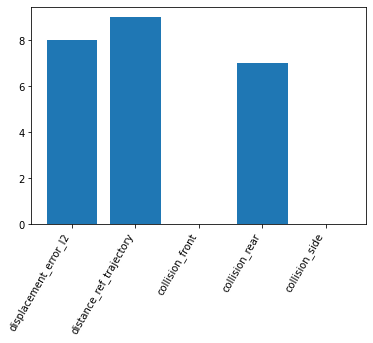

In [27]:
from src.validate.validator import CLEValidator
import matplotlib.pyplot as plt
import numpy as np

agg = CLEValidator(sim_outs)
fields = ["metric", "value"]
table = PrettyTable(field_names=fields)

values = []
names = []

for metric_name in agg:
    table.add_row([metric_name, agg[metric_name].item()])
    values.append(agg[metric_name].item())
    names.append(metric_name)

print(table)

plt.bar(np.arange(len(names)), values)
plt.xticks(np.arange(len(names)), names, rotation=60, ha='right')
plt.show()

In [ ]:
# might change with different rasterizer
mapAPI = MapAPI.from_cfg(dm, cfg)

def visualize_outputs(sim_outs, map_API):
    for sim_out in sim_outs: # for each scene
        vis_in = simulation_out_to_visualizer_scene(sim_out, map_API)
        # print(vis_in)
        # break
        show(visualize(sim_out.scene_id, vis_in))

output_notebook()

### Best ade

In [ ]:
# might change with different rasterizer

mapAPI = MapAPI.from_cfg(dm, cfg)
sim_outs_selected = [sim_outs[i] for i in sorted_ades_idx[-5:-1]]
visualize_outputs(sim_outs_selected, mapAPI)

### Worst ade

In [ ]:
# might change with different rasterizer
mapAPI = MapAPI.from_cfg(dm, cfg)
sim_outs_selected = [sim_outs[i] for i in sorted_ades_idx[:5]]
visualize_outputs(sim_outs_selected, mapAPI)